In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Adjust the input size after pooling
        self.fc2 = nn.Linear(512, 2)  # Output layer for 2 classes (carious, non-carious)

    def forward(self, x):
        # Convolutional layers with ReLU activations and max pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # Pooling layer (size 2x2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)

        # Flatten the output of the convolutional layers
        x = torch.flatten(x, 1)  # Flatten to a vector for the fully connected layer

        # Fully connected layers
        x = F.relu(self.fc1(x))
        features = x  # Features before the final output layer

        # Final output layer for classification (carious vs. non-carious)
        x = self.fc2(x)

        return features, x  # Return both features and predictions


<ipython-input-7-c6e72f991097>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))  # Load the saved state


Saving bwx-300x213.jpg to bwx-300x213.jpg


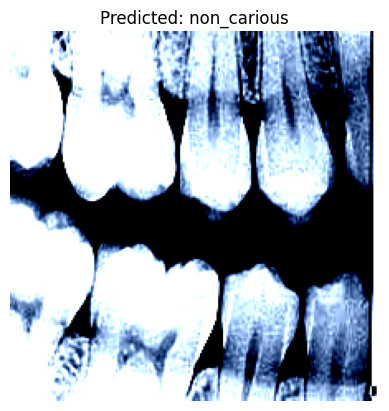

In [7]:
import cv2
import torch
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

# Load the trained model
model_path = "/content/custom_cnn.pth"
model = CustomCNN()  # Initialize the model (use the correct class name)
model.load_state_dict(torch.load(model_path))  # Load the saved state
model.eval()  # Set the model to evaluation mode

# Upload an image
uploaded = files.upload()
image_path = next(iter(uploaded.keys()))

# Load and preprocess the image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
img = cv2.resize(img, (224, 224))  # Resize to match model input size

# Normalize the image (match training normalization)
mean = np.array([0.485, 0.456, 0.406])  # Mean used for normalization in training
std = np.array([0.229, 0.224, 0.225])   # Std used for normalization in training
img = img.astype('float32') / 255.0  # Normalize to [0, 1] range
img = (img - mean) / std  # Normalize to the same distribution as training data

# Convert to tensor and add batch dimension
img_tensor = torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float()  # Ensure the tensor is float32

# Ensure the model is on the same device (CPU/GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)  # Move model to appropriate device
img_tensor = img_tensor.to(device)  # Move image tensor to appropriate device

# Predict
with torch.no_grad():
    features, output = model(img_tensor)  # Use both features and predictions from the model
    _, predicted = torch.max(output, 1)  # We use the second output (predictions)

# Class labels (make sure they are in the correct order)
class_labels = ["carious", "non_carious"]

# Plot the image and prediction
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {class_labels[predicted.item()]}")
plt.show()

# Print the prediction class label
print(f"Predicted: {class_labels[predicted.item()]}")
